# Circularity Measures

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import pickle
%matplotlib inline

In [2]:
import cplot

In [3]:
# again, this only works on startup!
from jax.config import config
config.update("jax_enable_x64", True)

In [8]:
def complex_standard_multivariate_normal_pdf(z, n=1):
    
    z = np.array(z).reshape(1, -1)

    location = np.zeros(n, dtype=complex)
    covariance_matrix = np.eye(n, dtype=complex)
    relation_matrix = np.zeros(n, dtype=complex).reshape(n,n)
    
    R = np.conjugate(relation_matrix).T * np.linalg.inv(covariance_matrix)
    P = np.conjugate(covariance_matrix) - R*relation_matrix
    scale = 1. / (np.pi**n * np.sqrt(np.linalg.det(covariance_matrix) * np.linalg.det(P)))
    
    exp1 = np.hstack([(np.conjugate(z) - np.conjugate(location)).T, (z - location).T])

    row1 = np.hstack([covariance_matrix, relation_matrix])
    row2 = np.hstack([np.conjugate(relation_matrix), np.conjugate(covariance_matrix)])
    exp2 = np.linalg.inv(np.vstack([row1, row2]))
    
    exp3 = np.vstack([(z-location), (np.conjugate(z) - np.conjugate(location))])
        
    return scale * np.exp(-0.5 * exp1 @ exp2 @ exp3)

(1, 100)


TypeError: Shapes of x (10, 10) and z (100, 100) do not match

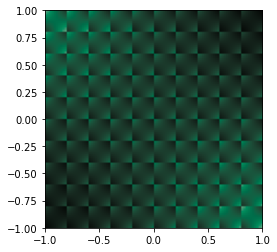

In [9]:
cplot.plot(complex_standard_multivariate_normal_pdf, (-1.,1.,10), (-1.,1.,10))

In [3]:
class MyDataset(Dataset):
    def __init__(self, data_folder, n_classes):

        self.X = []
        self.Y = []
        self.X_v = []
        self.metadata = []
        self.exps = []
        
        with open(data_folder + '.pkl', 'rb') as f:
            tmp = pickle.load(f)
            for a in tmp:
                self.X.append(tmp[a][0])
                self.X_v.append(tmp[a][1])
                self.Y.append(int(a.split('_c')[0]))
                self.metadata.append(tmp[a][2])
                self.exps.append(a.split('_')[1])

        self.X = np.stack(self.X)
        if len(self.X_v[0]) > 0:
            self.X_v = np.stack(self.X_v)
            self.dim_v = self.X_v.shape[1]
        else:
            ##1Hz data are not mandatory
            self.X_v = np.zeros(self.X.shape[0])
            self.dim_v = 0

        self.Y = np.array(self.Y)
        self.n_classes = n_classes

        self.nrow = self.X.shape[2]
        self.ncol = self.X.shape[3]
        self.n_channels = self.X.shape[1]
        print(f'    loaded {self.X.shape[0]} samples')

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idxs):
        x = self.X[idxs]
        y = self.Y[idxs]
        one_hot_y = np.eye(self.n_classes)[y]
        return [x, one_hot_y]

In [4]:
data_dir = '/home/mattia/Desktop/PhysicsofData/Internship/data/input/'

In [5]:
source_train = MyDataset(data_dir + 'source_train', n_classes=2)
source_test  = MyDataset(data_dir + 'source_test',  n_classes=2)
target_train = MyDataset(data_dir + 'target_train', n_classes=2)
target_test  = MyDataset(data_dir + 'target_test',  n_classes=2)

    loaded 2484 samples
    loaded 1055 samples
    loaded 604 samples
    loaded 615 samples


In [6]:
def circularity_coeff(dataset):
    
    cov_mat = 0.
    
    # Compute the covariance matrix among real and imaginary parts
    # of the whole dataset
    for i in tqdm(range(len(dataset)), leave=False):
        cov_mat += np.cov(dataset[i][0].real.flatten(), dataset[i][0].imag.flatten()) 
        
    # The covariance matrix will have the following structure:  [[Sx**2, Sxy], [Sxy, Sy**2]]
    cov_mat = cov_mat / len(dataset)

    # Compute the variance of Z:   Sz**2 = E[ |Z - E[Z]|**2 ] = Sx**2 + Sy**2
    Sx2 = cov_mat[0,0]
    Sy2 = cov_mat[1,1]
    Sz2 = cov_mat.trace() 
    
    # Get the covariance:   Sxy = E[(X-E[X])(Y-E[Y])]
    Sxy = cov_mat[0,1]
    
    # Compute the pseudo-variance:   Tz = E[ (Z-E[Z])**2 ] = Sx**2 - Sy**2 + 2iSxy
    Tz = Sx2 - Sy2 + 2.j*Sxy
    
    # Compute the circularity quotient:  rhoZ = Tz / Sz**2
    rhoZ = Tz / Sz2
    
    # Compute the correlation coefficient:  rho = Sxy / SxSy
    rho = Sxy / (np.sqrt(Sx2)*np.sqrt(Sy2))
    
    return rhoZ, rho

In [7]:
print('Source train:')
source_train_rhoZ, source_train_rho = circularity_coeff(source_train)
print('\tCircularity quotient: {:.5f},\t Correlation coefficient:{:.5f}'.format(source_train_rhoZ, source_train_rho))

print('Source test:')
source_test_rhoZ, source_test_rho = circularity_coeff(source_test)
print('\tCircularity quotient: {:.5f},\t Correlation coefficient:{:.5f}'.format(source_test_rhoZ, source_test_rho))

print('Target train:')
target_train_rhoZ, target_train_rho = circularity_coeff(target_train)
print('\tCircularity quotient: {:.5f},\t Correlation coefficient:{:.5f}'.format(target_train_rhoZ, target_train_rho))

print('Target test:')
target_test_rhoZ, target_test_rho = circularity_coeff(target_test)
print('\tCircularity quotient: {:.5f},\t Correlation coefficient:{:.5f}'.format(target_test_rhoZ, target_test_rho))

Source train:


  0%|          | 0/2484 [00:00<?, ?it/s]

	Circularity quotient: 0.99910+0.00000j,	 Correlation coefficient:0.00003
Source test:


  0%|          | 0/1055 [00:00<?, ?it/s]

	Circularity quotient: 0.99910+0.00000j,	 Correlation coefficient:0.00003
Target train:


  0%|          | 0/604 [00:00<?, ?it/s]

	Circularity quotient: 0.00593-0.00132j,	 Correlation coefficient:-0.00132
Target test:


  0%|          | 0/615 [00:00<?, ?it/s]

	Circularity quotient: 0.00632-0.00380j,	 Correlation coefficient:-0.00380


In [9]:
def generate_cmplx_distribution(cov_mat, shape):
    return np.random.multivariate_normal(np.zeros(2), cov_mat, size=shape).view(np.complex128)

<ipython-input-9-b3eabbd14781>:2: RuntimeWarning: covariance is not positive-semidefinite.
  return np.random.multivariate_normal(np.zeros(2), cov_mat, size=shape).view(np.complex128)


  0%|          | 0/5000 [00:00<?, ?it/s]

Class 0:
	Circularity quotient: 0.00028+0.50103j,	 Correlation coefficient:0.50103


  0%|          | 0/5000 [00:00<?, ?it/s]

Class 1:
	Circularity quotient: 0.00103-0.49977j,	 Correlation coefficient:-0.49977


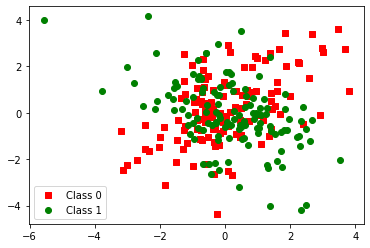

In [53]:
class0_data = generate_cmplx_distribution(cov_mat=np.array([[1.0, 2.],[2., 1.0]]), shape=(5000, 128))
class1_data = generate_cmplx_distribution(cov_mat=np.array([[1.0, -2.],[-2., 1.0]]), shape=(5000, 128))

plt.scatter(class0_data[0].real, class0_data[0].imag, c='red', marker='s', label='Class 0')
plt.scatter(class1_data[0].real, class1_data[0].imag, c='green', marker='o', label='Class 1')
plt.legend()

class0_rhoZ, class0_rho = circularity_coeff(np.expand_dims(class0_data, 1))
print('Class 0:')
print('\tCircularity quotient: {:.5f},\t Correlation coefficient:{:.5f}'.format(class0_rhoZ, class0_rho))

class1_rhoZ, class1_rho = circularity_coeff(np.expand_dims(class1_data, 1))
print('Class 1:')
print('\tCircularity quotient: {:.5f},\t Correlation coefficient:{:.5f}'.format(class1_rhoZ, class1_rho))

In [13]:
from importlib import reload

In [21]:
from complex_nn import Classifier_wrapper
reload(Classifier_wrapper)
from complex_nn.Classifier_wrapper import Haiku_Classifier

In [22]:
import torch
import haiku as hk
import jax
import jax.numpy as jnp
from complex_nn.Classifier_wrapper import Haiku_Classifier
from complex_nn.Cmplx_Optimizers import cmplx_adam
from complex_nn.Cmplx_Layers import *
from complex_nn.Cmplx_Activations import *
from complex_nn.utils import *

In [54]:
class NpyDataset(Dataset):
    
    def __init__(self, data, label):
        
        self.x = data
        self.y = np.full(len(data), label)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.x[idx].flatten())
        one_hot_y = torch.tensor(np.eye(2)[self.y[idx]])
        
        return (x, one_hot_y)

In [55]:
full_ds = torch.utils.data.ConcatDataset([NpyDataset(class0_data, label=0), NpyDataset(class1_data, label=1)])
train_ds, test_ds = torch.utils.data.random_split(full_ds, [8000, 2000])
train_dl = DataLoader(train_ds, batch_size=320, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=320, shuffle=False)

In [56]:
class CVNN(hk.Module):

    def __init__(self):

        super().__init__()
        self.fc1 = Cmplx_Linear(64)
        self.fc2 = Cmplx_Linear(16)
        self.fc3 = Cmplx_Linear(2)

        self.dropout = Dropout(0.2)
        self.act = cardioid

    def __call__(self, z, is_training):
        
        z = self.act(self.fc1(z))
        z = self.dropout(z, is_training)
        z = self.act(self.fc2(z))
        z = self.fc3(z)
        
        return z

Training for several epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

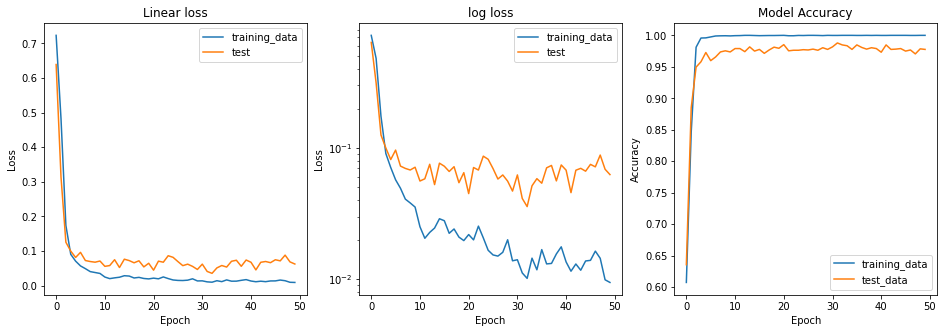

In [57]:
complex_hc = Haiku_Classifier(rng_seed=42, with_state=True)
history = complex_hc.train(n_epochs = 50, 
                     model = CVNN, 
                     optimizer = cmplx_adam(step_size=1e-2),
                     train_dataloader = train_dl,
                     test_dataloader = test_dl,
                     verbose = False)

small_training_summary(history)

In [58]:
class NN2CH(hk.Module):

    def __init__(self):

        super().__init__()
        self.real_fc1 = hk.Linear(64)
        self.real_fc2 = hk.Linear(16)
        
        self.imag_fc1 = hk.Linear(64)
        self.imag_fc2 = hk.Linear(16)
        
        self.out = hk.Linear(2)
        
        self.batchnorm_1D = hk.BatchNorm(create_scale=True, create_offset=True, decay_rate=0.9, data_format='NC')
        self.dropout = Dropout(0.2)
        self.act = jax.nn.relu

    def __call__(self, z, is_training):
        
        x = z.real
        y = z.imag

        x = self.act(self.real_fc1(x))
        x = self.dropout(x, is_training)
        x = self.batchnorm_1D(x, is_training)
        x = self.act(self.real_fc2(x))
        
        y = self.act(self.imag_fc1(y))
        y = self.dropout(y, is_training)
        y = self.batchnorm_1D(y, is_training)
        y = self.act(self.imag_fc2(y))
        
        xy = jnp.concatenate([x,y], axis=-1)
        out = self.out(xy)

        return out

Training for several epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation loss:   0%|          | 0/7 [00:00<?, ?it/s]

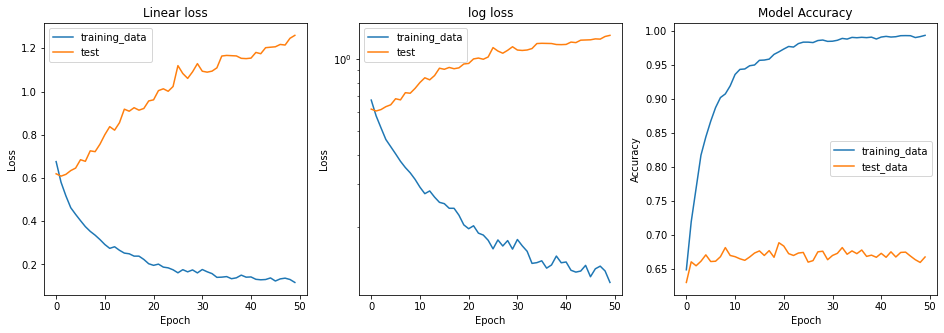

In [59]:
hc_2ch = Haiku_Classifier(rng_seed=42, with_state=True)
history2 = complex_hc.train(n_epochs = 50, 
                     model = NN2CH, 
                     optimizer = jax.experimental.optimizers.adam(step_size=1e-2),
                     train_dataloader = train_dl,
                     test_dataloader = test_dl,
                     verbose = False)

small_training_summary(history2)